fit quadrics to shape, batch option below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../utils/')
import neural_quadrics as nq
import mesh_tools as mt
from quadric_meshing import SurfaceFromQuadrics
import torch
from torch import nn
from tqdm import tqdm
from pytorch3d.loss import chamfer_distance
from meshplot import plot
from IPython.display import clear_output
import trimesh
import igl

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def uniform_edge_sampling(N, v, boundary_edges, boundary_normals):
    edge_length = np.sqrt(((v[boundary_edges[:, 1]]-v[boundary_edges[:, 0]])**2).sum(-1))
    selected_edges = np.random.choice(len(edge_length), N, p=edge_length/edge_length.sum())
    lambdas = np.random.rand(len(selected_edges))[:, None]
    sampled_points = v[boundary_edges[selected_edges][:, 1]]*lambdas + v[boundary_edges[selected_edges][:, 0]]*(1-lambdas)
    pseudo_normals = v[boundary_edges[selected_edges][:, 1]] - v[boundary_edges[selected_edges][:, 0]]
    pseudo_normals = np.cross(pseudo_normals, boundary_normals[selected_edges])
    pseudo_normals /= np.sqrt((pseudo_normals**2).sum(-1, keepdims=True))
    return sampled_points, boundary_normals[selected_edges], pseudo_normals

def complete_basis(k):
    x = np.random.randn(len(k), 3)  # take a random vector
    x -= (x*k).sum(-1, keepdims=True) * k       # make it orthogonal to k
    x /= np.sqrt((x**2).sum(-1, keepdims=True))  # normalize it
    y = np.cross(k, x) 
    return x, y

In [21]:
def get_boundary_edge(f, normals):
    boundary_edges = igl.boundary_facets(f)
    is_f = f[None, :, :]==boundary_edges[:, 0, None, None]
    is_s = f[None, :, :]==boundary_edges[:, 1, None, None]
    is_face = np.logical_or(is_f, is_s).sum(-1)==2
    return boundary_edges, normals[is_face.argmax(-1)]

In [43]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'

GRID_N = 32
model_name = '../../data/ShirtNoCoat.obj'

GRID_N = 16
model_name = 'TShirtNoCoat.obj'


SURFACE_SAMPLING = 25000 * (GRID_N/16)**2
EDGE_SAMPLING = 2000 * (GRID_N/16)

    
# model_name = 'coverrear.off'
v, f = mt.load_and_sample_shape(model_name, '', 0, 'NDC')
ref_mesh = trimesh.Trimesh(v,f)

total_area = igl.doublearea(v,f).sum()/2

samples, face_index = trimesh.sample.sample_surface_even(ref_mesh, int(SURFACE_SAMPLING*total_area))
samples = np.array(samples)
normals = np.array(ref_mesh.face_normals[face_index])
boundary_edges, boundary_normals = get_boundary_edge(f, igl.per_face_normals(v,f, np.ones(3)))

boundary_edge_length = np.sqrt(((v[boundary_edges[:, 1]]- v[boundary_edges[:, 0]])**2).sum(-1)).sum()
sampled_edges, sampled_edges_normals, pseudo_normals = uniform_edge_sampling(int(EDGE_SAMPLING*boundary_edge_length), v, boundary_edges, boundary_normals)


In [44]:
points = mt.mesh_grid(GRID_N, True)
V = nq.MovingQuadrics(points[mt.mask_relevant_voxels(GRID_N, samples)], device)

L=[]
global optimizer
optimizer = None

def reset_optimizer(lr=.01):
    global optimizer
    optimizer = torch.optim.Adam([V.points], lr)
reset_optimizer()


# # pnx, pny = complete_basis(pseudo_normals)
# tensor_surface = torch.tensor(np.concatenate((samples, sampled_edges, sampled_edges)), dtype=torch.float32).to(device)
# tensor_normals = torch.tensor(np.concatenate((normals, pnx, pny)), dtype=torch.float32).to(device)
tensor_surface = torch.tensor(np.concatenate((samples, sampled_edges, sampled_edges)), dtype=torch.float32).to(device)
tensor_normals = torch.tensor(np.concatenate((normals, sampled_edges_normals, pseudo_normals)), dtype=torch.float32).to(device)

len(tensor_surface)

91883

In [45]:
# mp = plot(v,f)
# mp.add_points(samples)

# mp.add_points(sampled_edges, shading={'point_color': 'black'})
# # mp.add_edges(v, boundary_edges, shading={"line_color": "red", "line_width": .0001})

In [46]:
# mt.export_obj(v,f, 'boundary_gt')

### Further optim

In [47]:
def train_simple(V, repulsion_fac=0, sample_fac=1):
    optimizer.zero_grad()
    masks = torch.rand_like(tensor_surface[:, 0]) < sample_fac
    loss = chamfer_distance(tensor_surface[masks][None,:], V.points[None,:])[0].mean()
    if repulsion_fac>0:
        loss += -repulsion_fac*(V.distance_to_centroids(V.points,V.points).topk(2, 0, False).values[1].mean())
    x = loss.item()
    loss.backward()
    optimizer.step() 
    return x


100%|██████████| 300/300 [00:03<00:00, 80.00it/s]


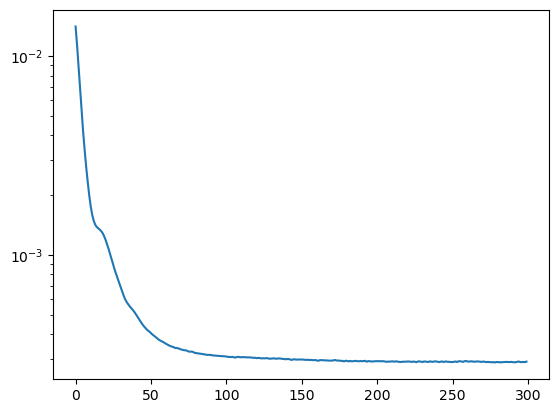

In [48]:
for i in tqdm(range(300)):
    L.append((train_simple(V, repulsion_fac=.1, sample_fac=1)))
        # scheduler.step()
plt.plot(L)
plt.yscale('log')

### Simple plot

In [49]:
V.cluster_samples_quadrics_normals(tensor_surface, tensor_normals)

In [50]:
plot(*V.quadric_ellipse_mesh(size=0.02, subdivisions=0))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.004296…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_30b6c198-66df-45f6-ad23-325050584279'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_90e8f06c-670e-4bdb-9004-c46602146b33'.

In [51]:
# torch.save(V, 'boundary.pt')

In [53]:
nvertices, in_triangle, in_scores = V.min_cut_surface(32, return_scores=True, open_treshold=.4)
mp = plot(nvertices, in_triangle)
# mp.add_mesh(*V.quadric_ellipse_mesh())

mt.export_obj(nvertices, in_triangle, 'tshirt')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.003803…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_629b1c92-362f-4daf-99b6-5e8f96bdf960'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_7a4ddcf8-860e-4807-9980-df3f64b0aa38'.

In [ ]:
import neural_quadrics as nq
import sys
sys.path.insert(1,'../learning/')


M = torch.load('../learning/models/model_multiple_quadrics_split_free.pt')
mt.count_parameters(M.encoder) / mt.count_parameters(M)

mt.count_parameters(M)/1000